In [23]:
import os
import datetime as dt
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    f1_score,
    recall_score,
)
from sklearn.manifold import TSNE

Data preparation

In [24]:
users_items = pd.read_json("../data/limited_10_3_sweaters_reviews_sentiment.json")

In [25]:
dt.datetime.fromtimestamp(users_items["unixReviewTime"].iloc[0] // 1000)
month_season_dict = {
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 1,
    6: 2,
    7: 2,
    8: 2,
    9: 3,
    10: 3,
    11: 3,
    12: 0,
}
users_items["season"] = users_items["unixReviewTime"].apply(
    lambda x: month_season_dict[dt.datetime.fromtimestamp(x // 1000).month]
)
games_list = users_items["item_id"].tolist()
users_items = users_items[users_items["sentiment"] != 0]
negative = users_items[users_items["sentiment"] == -2]
users_items = users_items[users_items["sentiment"] != -2]
grouped = users_items.groupby("reviewer_id").size().reset_index(name="counts")
grouped = grouped[grouped["counts"] >= 4]
active_users = grouped["reviewer_id"].values.tolist()
users_items = users_items[users_items["reviewer_id"].isin(active_users)]

Encoder architecture

In [26]:
class SequentialEncoder(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_sizes: list[int],
        output_emb_size: int,
    ):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_sizes[0])
        layers = []
        for in_size, out_size in zip(hidden_sizes[:-1], hidden_sizes[1:]):
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], output_emb_size))

        self.mlp = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.lstm.forward(x)[1][0]
        x = torch.squeeze(x)
        return self.mlp(x)

Decoder architecture

In [27]:
class SequentialDecoder(nn.Module):
    def __init__(self, game_embed=512, hidden_sizes=[256, 128], emb_size=32):
        super().__init__()
        layers = []
        for in_size, out_size in zip(
            [emb_size + game_embed] + hidden_sizes[:-1], hidden_sizes
        ):
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))

        layers.append(nn.Linear(hidden_sizes[-1], 1))
        layers.append(nn.Sigmoid())
        self.sequence = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.sequence(x)

In [28]:
device = torch.device("cuda")

In [29]:
items_embs_path = os.path.join("..", "data", "items_embs.pickle")
if os.path.isfile(items_embs_path):
    with open(items_embs_path, "rb") as f:
        items_embs = pickle.load(f)

with open(os.path.join("..", "data", "encoder_30.pkl"), "rb") as f:
    encoder = pickle.load(f)
    encoder.to(device)
with open(os.path.join("..", "data", "decoder_20.pkl"), "rb") as f:
    decoder = pickle.load(f)
    decoder.to(device)
with open(os.path.join("..", "data",'x_test.npy'), 'rb') as f:
    X_test= np.load(f,allow_pickle=True)

with open(os.path.join("..", "data",'x_test_last.npy'), 'rb') as f:
    X_test_last =np.load(f,allow_pickle=True)

In [30]:
games_list = list(set(games_list))
games_embeds = []
for game in games_list:
    games_embeds.append(items_embs[game].to(device))

In [31]:
def predict_for_user(user_seq, games_embeds, encoder, decoder):
    games_preds = []
    with torch.no_grad():
        user_embed = encoder(user_seq.to(device))
        for game in games_embeds:
            game_embedding = game.reshape(-1).to(device)
            result = torch.cat((user_embed, game_embedding), dim=0)
            y_pred = decoder(result)
            games_preds.append(y_pred)

    max_idx = games_preds.index(max(games_preds))
    return games_embeds[max_idx]

In [32]:
def predict_on_test(X_test, X_last, encoder, decoder, game_embeds, games_list):
    y_preds = []
    for x in X_test:
        game = predict_for_user(x, game_embeds, encoder, decoder)
        y_preds.append(game.cpu().numpy())
    
    y_pred,y_true =[], []
    for pred, y in zip(y_preds, X_last):

        if np.all(pred == y):
            y_true.append(1)
            y_pred.append(1)
        else:
            y_true.append(1)
            y_pred.append(0)

    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"Precision: {precision_score(y_true, y_pred)}")
    print(f"Recall: { recall_score(y_true, y_pred)}")
    print(f"F1 score: {f1_score(y_true, y_pred)}")

## Presentation


General model 


![](model.png "T")

Encoder and sequence representation

In [33]:
encoder = encoder.eval()
representations = [encoder(x.to(device)) for x in X_test]
representations = torch.stack(representations)
encoder 

SequentialEncoder(
  (lstm): LSTM(516, 256)
  (mlp): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
)

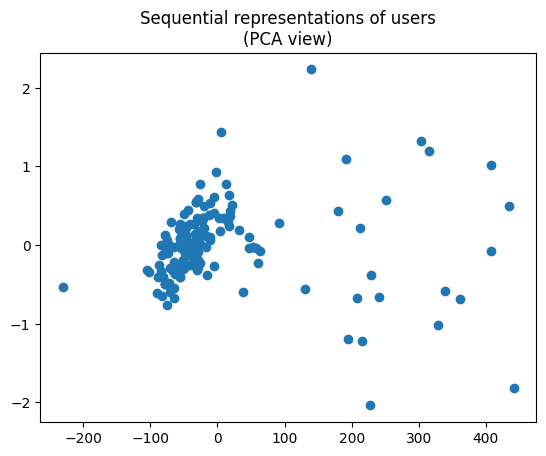

In [34]:
pca = PCA(n_components=2)
representations_pca = pca.fit_transform(representations.detach().cpu().numpy())

plt.scatter(representations_pca[:, 0], representations_pca[:, 1])
plt.title("Sequential representations of users\n(PCA view)")
plt.show()

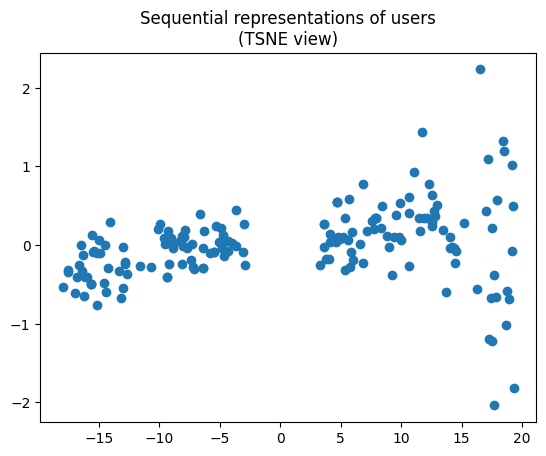

In [35]:
tsne = TSNE(n_components=2)
representations_tsne = tsne.fit_transform(representations.detach().cpu().numpy())

plt.scatter(representations_tsne[:, 0], representations_pca[:, 1])
plt.title("Sequential representations of users\n(TSNE view)")
plt.show()

Decoder

In [36]:
decoder

SequentialDecoder(
  (sequence): Sequential(
    (0): Linear(in_features=544, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

Loss through training

![](loss.png "T")

Encoder Decoder cobination:

![](new_usr.png "T")

In [22]:
predict_on_test(
    encoder=encoder,
    decoder=decoder,
    X_test=X_test,
    X_last=X_test_last,
    game_embeds=games_embeds,
    games_list=games_list,
)

Accuracy: 0.04046242774566474
Precision: 1.0
Recall: 0.04046242774566474
F1 score: 0.07777777777777778
